## Purpose: Using Machine Learning, create a model that will attempt to determine if an employee is at risk for leaving the organization
## Authors: Group 6
## Date: June 1, 2022

### Import libraries


In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Customize notebook with jupyterthemes
from jupyterthemes import jtplot as jt
jt.style(theme = 'grade3', context = 'notebook', ticks = True, grid = False)
# Postgres DB connector
import psycopg2

### Read Data


In [2]:
# Password for Postgres DB
from config import postpw
# print(postpw)

In [3]:
# Connection String for the Postgress database - Replace yourPW with the password you used when you installed Postgres
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format('127.0.0.1', 5432, 'Group6Final', 'postgres', postpw))

In [4]:
SQL = """SELECT "Age",
"Attrition",
"BUSINESSTRAVEL",
"DailyRate",
"DEPARTMENT",
"DistanceFromHome",
"Education",
"EDUCATIONFIELD",
"EmployeeCount",
"EmployeeNumber",
"EnvironmentSatisfaction",
"GENDER",
"HourlyRate",
"JobInvolvement",
"JobLevel",
"JOBROLE",
"JobSatisfaction",
"MARITALSTATUS",
"MonthlyIncome",
"MonthlyRate",
"NumCompaniesWorked",
"Over18",
"OverTime",
"PercentSalaryHike",
"PerformanceRating",
"RelationshipSatisfaction",
"StandardHours",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"WorkLifeBalance",
"YearsAtCompany",
"YearsInCurrentRole",
"YearsSinceLastPromotion",
"YearsWithCurrManager",
"NumberProjects",
"WorkplaceAccident"
FROM "Employee_Status" AS ES
JOIN "CD_TRAVEL" CDT ON ES."BusinessTravel_FK" = CDT."BUSINESSTRAVEL_FK"
JOIN "CD_DEPARTMENT" CDD ON ES."Department_FK" = CDD."DEPARTMENT_FK"
JOIN "CD_EDUCATIONFIELD" CDE ON ES."EducationField_FK" = CDE."EDUCATIONFIELD_FK"
JOIN "CD_GENDER" CDG ON ES."Gender_FK" = CDG."GENDER_FK"
JOIN "CD_ROLE" CDR ON ES."JobRole_FK" = CDR."JOBROLE_FK"
JOIN "CD_M_STATUS" CDS ON ES."MaritalStatus_FK" = CDS."MARITALSTATUS_FK""" + '"'

In [5]:
# Need to add the double quotes back in at the end
SQL 

'SELECT "Age",\n"Attrition",\n"BUSINESSTRAVEL",\n"DailyRate",\n"DEPARTMENT",\n"DistanceFromHome",\n"Education",\n"EDUCATIONFIELD",\n"EmployeeCount",\n"EmployeeNumber",\n"EnvironmentSatisfaction",\n"GENDER",\n"HourlyRate",\n"JobInvolvement",\n"JobLevel",\n"JOBROLE",\n"JobSatisfaction",\n"MARITALSTATUS",\n"MonthlyIncome",\n"MonthlyRate",\n"NumCompaniesWorked",\n"Over18",\n"OverTime",\n"PercentSalaryHike",\n"PerformanceRating",\n"RelationshipSatisfaction",\n"StandardHours",\n"StockOptionLevel",\n"TotalWorkingYears",\n"TrainingTimesLastYear",\n"WorkLifeBalance",\n"YearsAtCompany",\n"YearsInCurrentRole",\n"YearsSinceLastPromotion",\n"YearsWithCurrManager",\n"NumberProjects",\n"WorkplaceAccident"\nFROM "Employee_Status" AS ES\nJOIN "CD_TRAVEL" CDT ON ES."BusinessTravel_FK" = CDT."BUSINESSTRAVEL_FK"\nJOIN "CD_DEPARTMENT" CDD ON ES."Department_FK" = CDD."DEPARTMENT_FK"\nJOIN "CD_EDUCATIONFIELD" CDE ON ES."EducationField_FK" = CDE."EDUCATIONFIELD_FK"\nJOIN "CD_GENDER" CDG ON ES."Gender_FK" = CD

In [6]:
# Read the file into a dataframe
hr_df = pd.read_sql_query(SQL, conn)
hr_df_copy = hr_df 

### Initial Analysis
- Any missing elements that need to be fixed
- Fix data issues


In [7]:
# Check the data and column names
hr_df.head()

,Age,Attrition,BUSINESSTRAVEL,DailyRate,DEPARTMENT,DistanceFromHome,Education,EDUCATIONFIELD,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,2,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,5,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,7,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,5,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,2,0


In [8]:
# Rename column names so they are all consistent
hr_df.rename(columns = {'BUSINESSTRAVEL':'BusinessTravel','DEPARTMENT':'Department','EDUCATIONFIELD':'EducationField','GENDER':'Gender','JOBROLE':'JobRole','MARITALSTATUS':'MaritalStatus' }, inplace = True)

In [9]:
# Verify the rename 
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'NumberProjects', 'WorkplaceAccident'],
      dtype='object')

In [10]:
# Check number of rows/columns
hr_df.shape

(1470, 37)

In [11]:
# Check for null values
hr_df.isnull().values.any()

False

In [12]:
# Another method to check for null values
hr_df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [13]:
# Another check for null values
hr_df.isnull()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1466,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1467,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1468,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Count of unique values in each column
hr_df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [15]:
# Appears that columns EmployeeCount, Over18 and StandardHours all contain only 1 value
# Also, the EmployeeNumber is just an ID so it can be dropped

In [16]:
# Before we drop verify EmployeeCount values are the same for all employees
print(hr_df['EmployeeCount'].nunique())
print(hr_df['EmployeeCount'].unique())

1
[1]


In [17]:
# Before we drop verify Over18 values are the same for all employees
print(hr_df['Over18'].nunique())
print(hr_df['Over18'].nunique())

1
1


In [18]:
# Before we drop verify StandardHours values are the same for all employees
print(hr_df['StandardHours'].nunique())
print(hr_df['StandardHours'].unique())

1
[80]


In [19]:
hr_df = hr_df.drop(columns=['EmployeeNumber','EmployeeCount','Over18','StandardHours'])

In [20]:
# Verify 4 columns dropped
hr_df.shape

(1470, 33)

### Exploratory Phase
- Get data statistics 
- Visualize the data

In [21]:
# determine data types by column
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [22]:
# Which columns are considered categorical, we need this info later for the encoding
hr_df.select_dtypes(include='int64').columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

In [23]:
# Which columns are considered categorical, we need this info later for the encoding
hr_df.select_dtypes(include='object').columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

In [24]:
# How many numerical features
len(hr_df.select_dtypes(include='int64').columns)

25

In [25]:
# get df stats
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [26]:
# see all the columns with descriptive stats
pd.set_option('display.max_columns', None)
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [27]:
# random sample of the df
hr_df.sample(7)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
1204,48,Yes,Travel_Frequently,708,Sales,7,2,Medical,4,Female,95,3,1,Sales Representative,3,Married,2655,11740,2,Yes,11,3,3,2,19,3,3,9,7,7,7,2,0
1366,39,No,Non-Travel,1251,Sales,21,4,Life Sciences,1,Female,32,1,2,Sales Executive,3,Married,5736,3987,6,No,19,3,3,1,10,1,3,3,2,1,2,2,0
318,27,No,Travel_Rarely,1220,Research & Development,5,3,Life Sciences,3,Female,85,3,1,Research Scientist,2,Single,2478,20938,1,Yes,12,3,2,0,4,2,2,4,3,1,2,6,0
1379,27,Yes,Travel_Frequently,1337,Human Resources,22,3,Human Resources,1,Female,58,2,1,Human Resources,2,Married,2863,19555,1,No,12,3,1,0,1,2,3,1,0,0,0,2,0
1433,25,No,Travel_Rarely,1382,Sales,8,2,Other,1,Female,85,3,2,Sales Executive,3,Divorced,4907,13684,0,Yes,22,4,2,1,6,3,2,5,3,0,4,2,0
701,53,No,Travel_Rarely,1376,Sales,2,2,Medical,3,Male,45,3,4,Manager,3,Divorced,14852,13938,6,No,13,3,3,1,22,3,4,17,13,15,2,4,0
281,42,No,Travel_Rarely,635,Sales,1,1,Life Sciences,2,Male,99,3,2,Sales Executive,3,Married,4907,24532,1,No,25,4,3,0,20,3,3,20,16,11,6,3,0


<AxesSubplot:xlabel='Education', ylabel='DailyRate'>

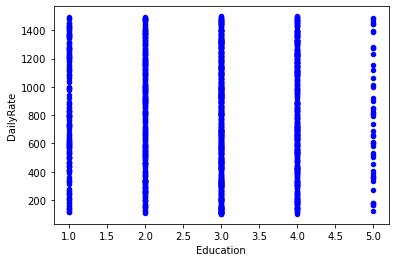

In [28]:
# look at running_time vs runtime using a scatter plot
hr_df.plot(x='Education', y='DailyRate', kind='scatter', color = 'b')

In [29]:
# Get a count of the target variable values
print("Count of Employees who stayed: ", (hr_df.Attrition == 'No').sum())
print("Count of Employees who left: ", (hr_df.Attrition == 'Yes').sum())

Count of Employees who stayed:  1233
Count of Employees who left:  237


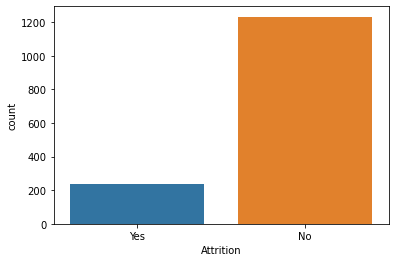

In [30]:
# Plot the target variable, how many instances of each value
sns.countplot(x=hr_df['Attrition'])
plt.show()

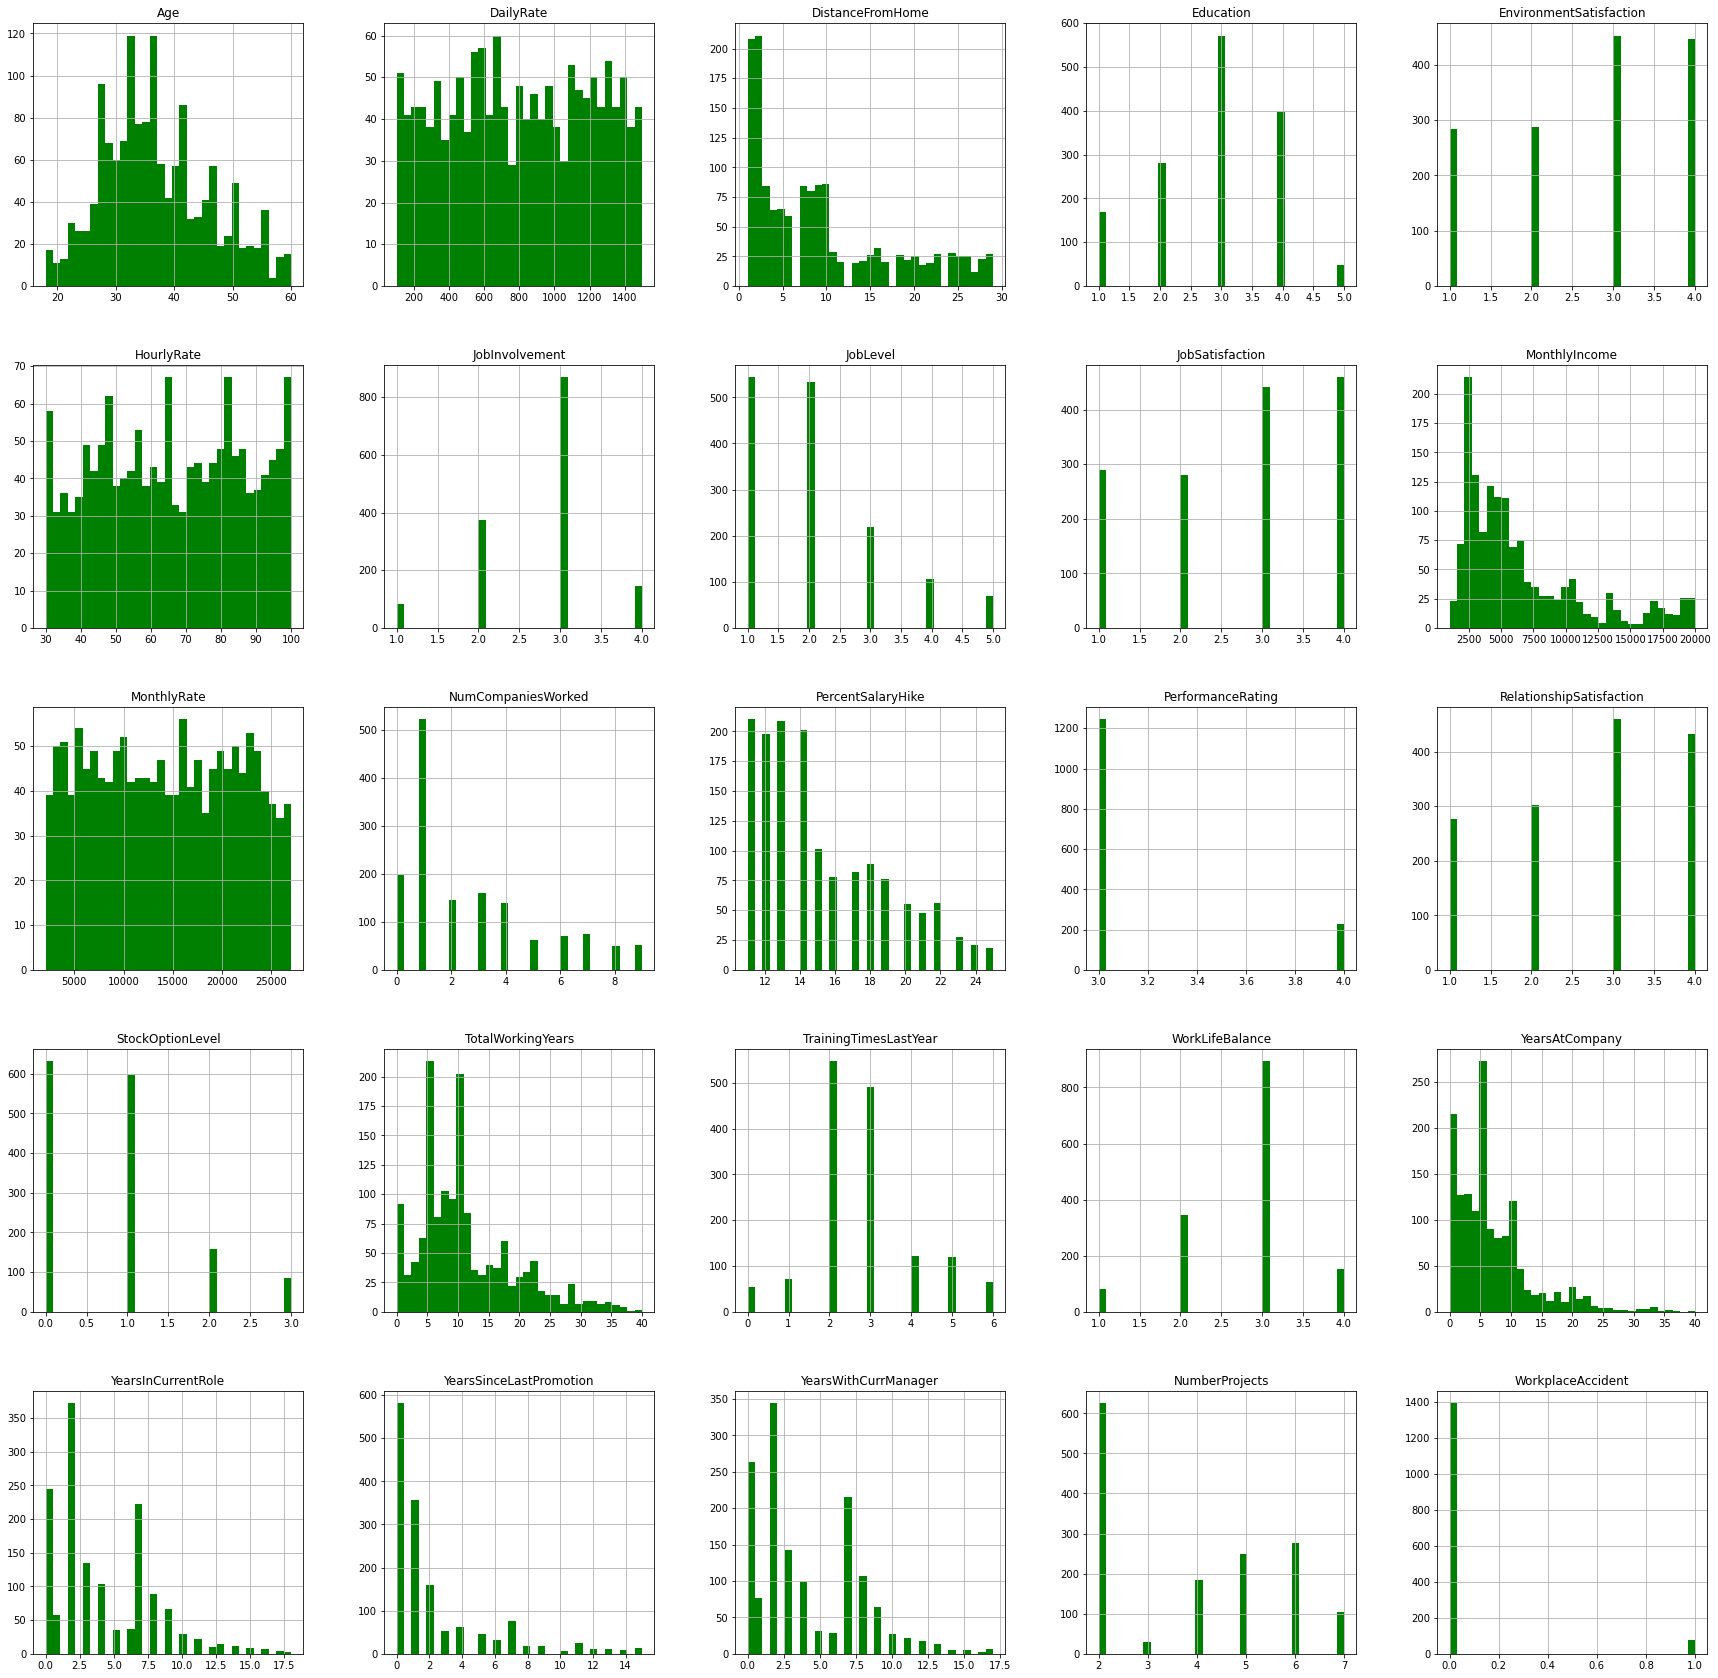

In [31]:
# Examine the distribution of the numerical features
hr_df.hist(bins = 33, figsize = (30,30), color = 'g');

In [32]:
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

<AxesSubplot:xlabel='Department', ylabel='count'>

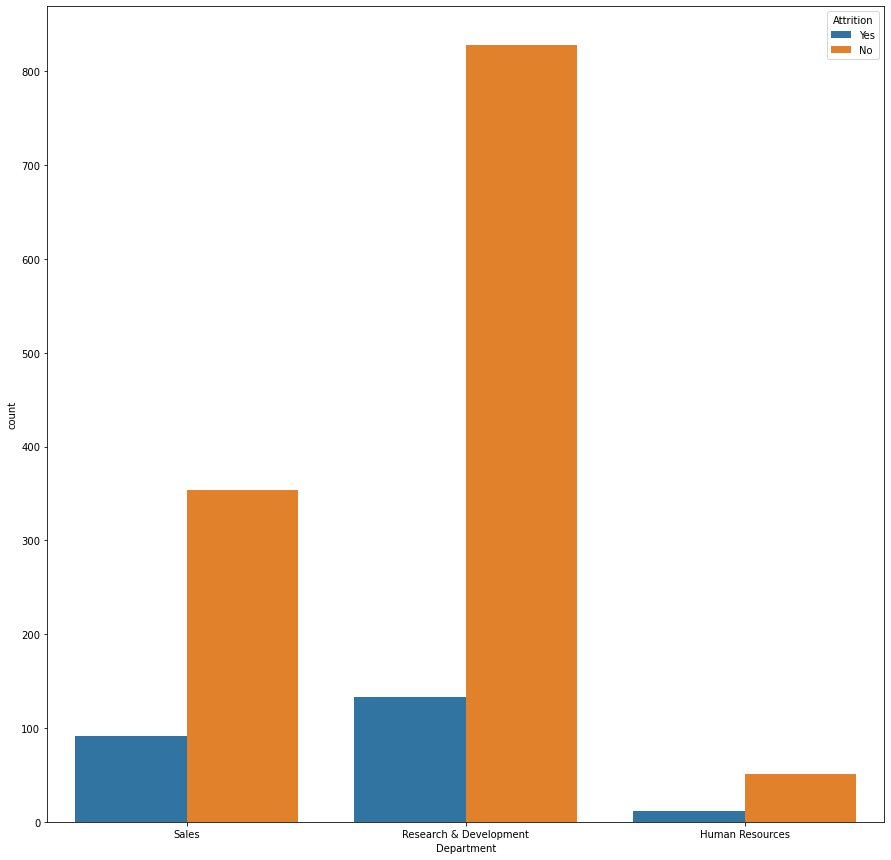

In [33]:
plt.figure(figsize=[15,15])
plt.subplot(111)
sns.countplot(x = 'Department', hue = 'Attrition', data = hr_df)

<AxesSubplot:xlabel='NumberProjects', ylabel='count'>

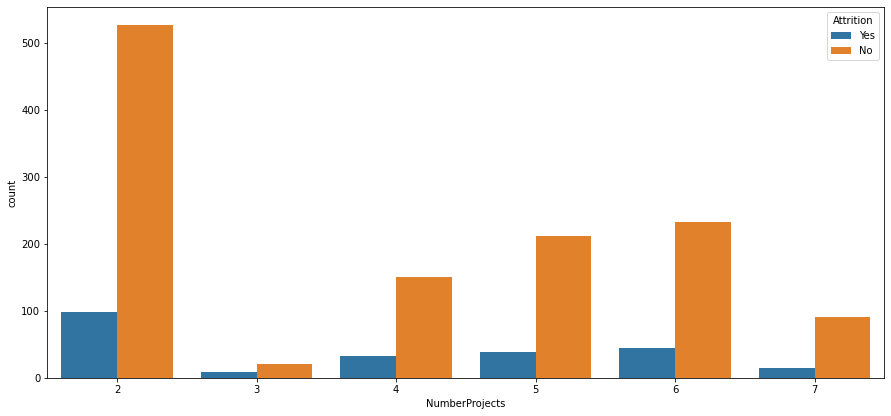

In [34]:
plt.figure(figsize=[15,15])
plt.subplot(211)
sns.countplot(x = 'NumberProjects', hue = 'Attrition', data = hr_df)

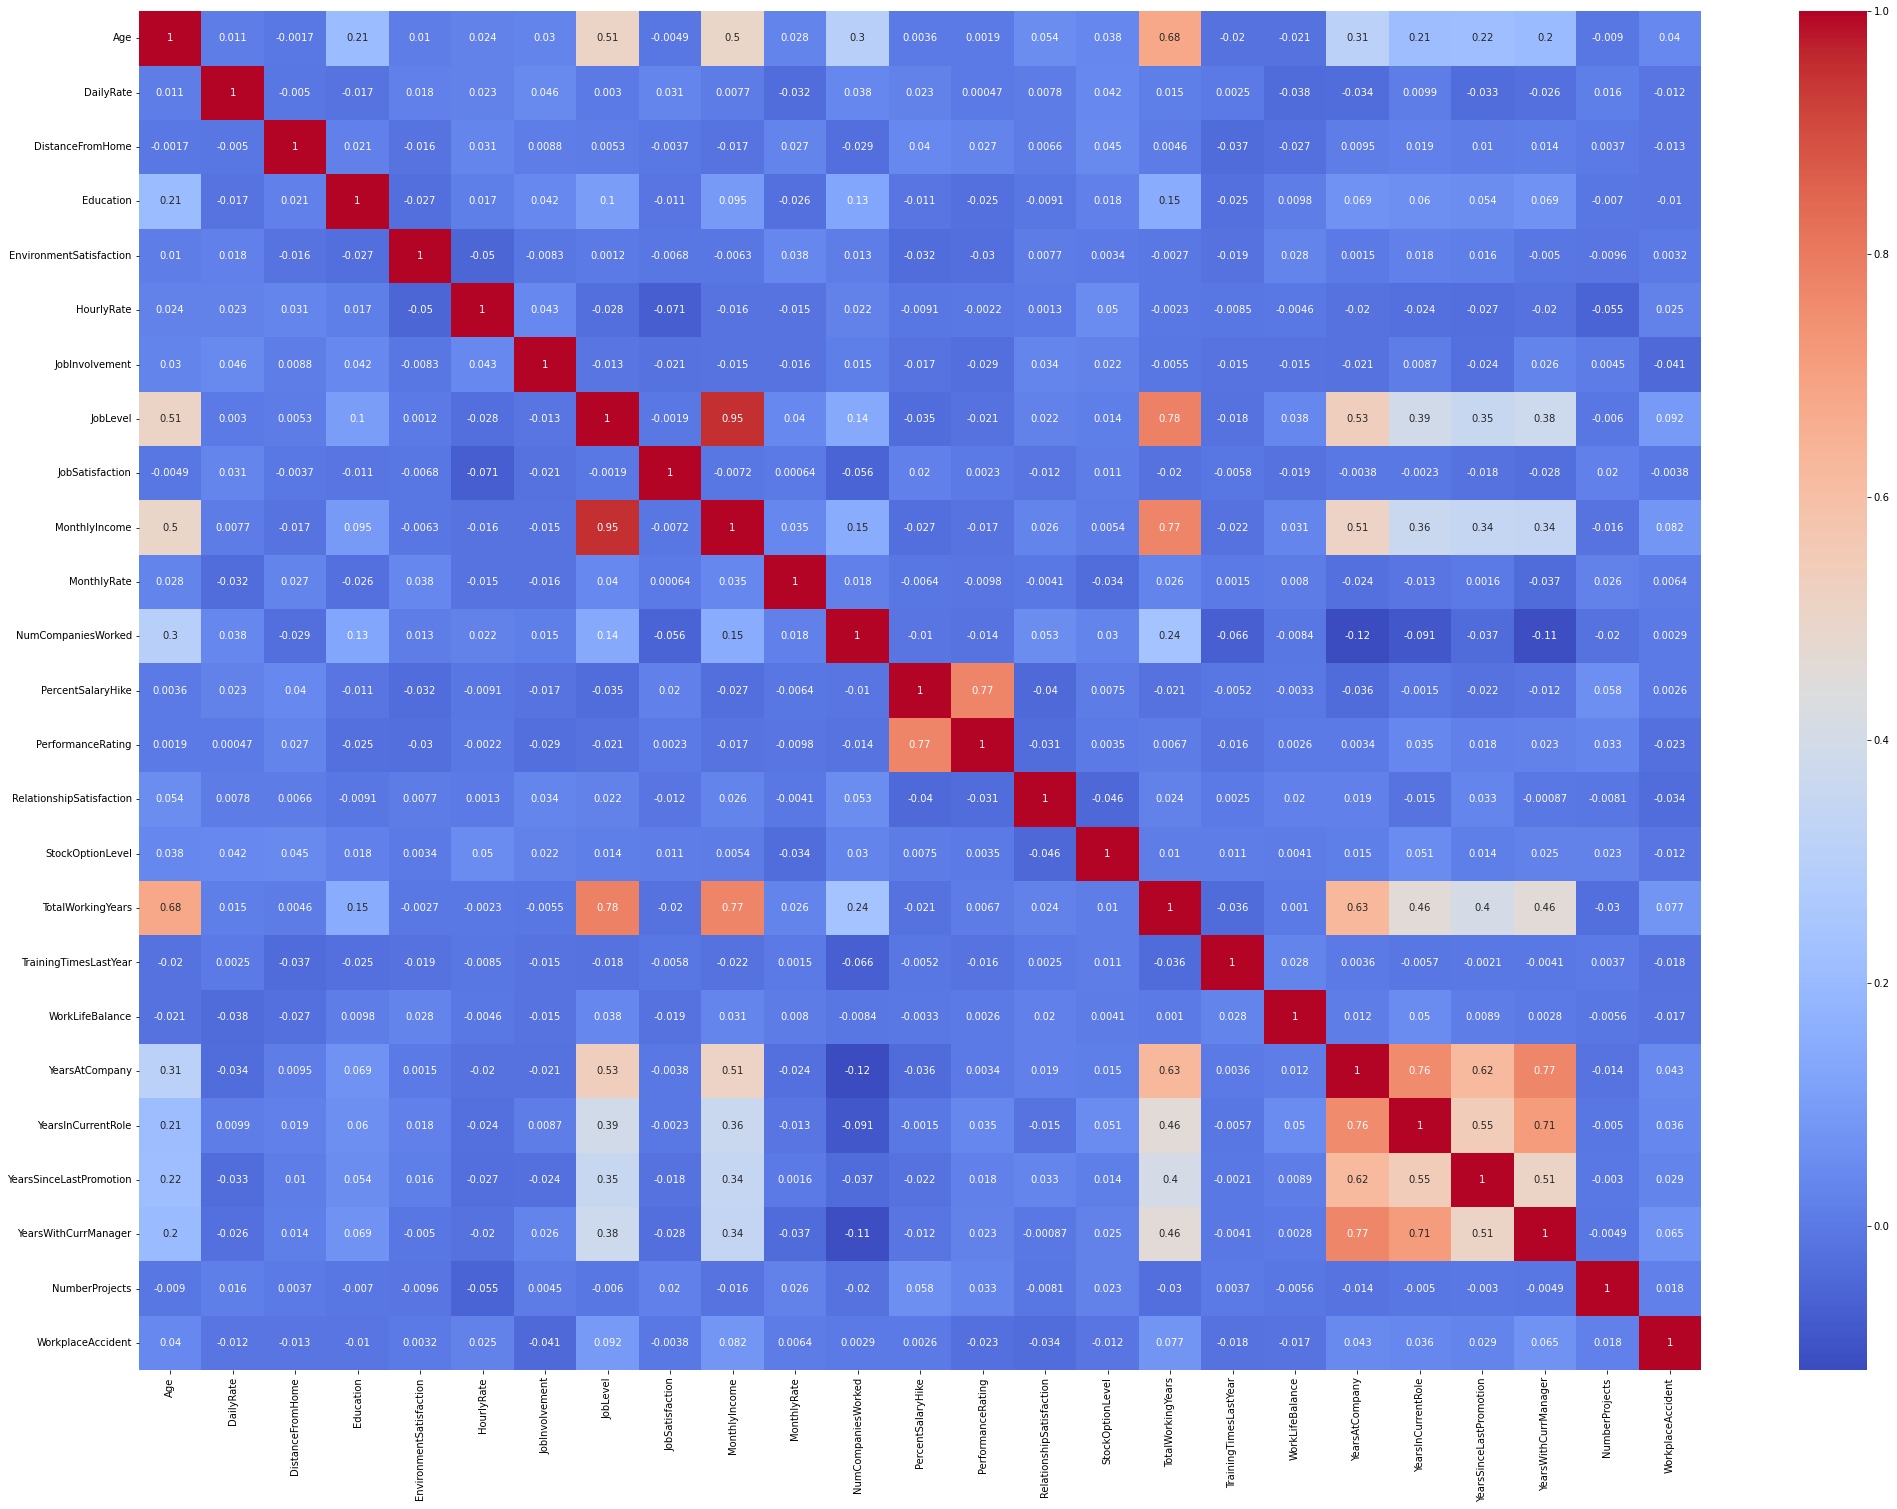

In [35]:
import seaborn as sns
# Examine correlations between features
correlation_matrix = hr_df.corr()
plt.figure(figsize=(35, 25))
heat_map = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm' )

### Transform Phase
- One hot encoding
- Reduction/Scaling


In [36]:
# Before OneHotEncoder check the number of rows and columns
hr_df.shape

(1470, 33)

In [37]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
#generate categorical variable list
hr_cat = hr_df.dtypes[hr_df.dtypes == "object"].index.tolist()

# check unique values
print(hr_df[hr_cat].nunique())

enc = OneHotEncoder(sparse=False)

#fit/transform
hr_encode = pd.DataFrame(enc.fit_transform(hr_df[hr_cat]))

# add names to df
hr_encode.columns = enc.get_feature_names_out(hr_cat)

# look at it
hr_encode.head()

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
OverTime          2
dtype: int64


,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [38]:
# merge/drop originals

hr_df = hr_df.merge(hr_encode, left_index=True, right_index=True)
hr_df = hr_df.drop(hr_cat, 1)

hr_df.head()

C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [39]:
hr_df.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident', 'Attrition_No', 'Attrition_Yes',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 

In [40]:
# After OneHotEncoder check the number of rows and columns and the length, which should be 0
#   if all categorical columns are encoded
print(hr_df.shape)
print(len(hr_df.select_dtypes(include = "object").columns))

(1470, 55)
0


In [41]:
# split data into feature/target
y = hr_df['Attrition_Yes'].values
X = hr_df.drop(columns=['Attrition_Yes', 'Attrition_No'])
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [42]:
print(y)

[1. 0. 1. ... 0. 0. 0.]


In [43]:
# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=78)

In [44]:
print("X_train {}".format(X_train.shape))
print("X_test {}".format(X_test.shape))
print("y_train {}".format(y_train.shape))
print("y_test {}".format(y_test.shape))

X_train (1176, 53)
X_test (294, 53)
y_train (1176,)
y_test (294,)


In [45]:
# Reduction/Scaling

from sklearn.preprocessing import StandardScaler 
# Create instance
scaler = StandardScaler()

# Fit 
X_scaler = scaler.fit(X_train)

# Scale 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
X_train_scaled

array([[ 3.57156995e-01, -1.32052987e-01,  3.77850497e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-8.64144324e-01,  4.76963816e-01, -8.79868677e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-7.53116932e-01,  1.08598062e+00,  5.34744547e-04, ...,
        -6.84225689e-01, -1.59107873e+00,  1.59107873e+00],
       ...,
       [-1.97979968e-01, -8.42986888e-01, -6.28324842e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-1.41928129e+00, -6.66496304e-01,  1.88711351e+00, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-6.42089539e-01, -1.16365288e+00,  5.34744547e-04, ...,
         1.46150607e+00, -1.59107873e+00,  1.59107873e+00]])

In [47]:
X_test_scaled

array([[ 1.35102210e-01,  1.71985525e+00,  1.26306662e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-8.64144324e-01, -9.00159894e-01, -1.25237173e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [ 5.79211781e-01,  1.66765381e+00, -5.02552925e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       ...,
       [ 2.46667746e+00,  1.57070828e+00,  2.01288542e+00, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01],
       [ 1.91154049e+00,  4.17305027e-01, -1.00564059e+00, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01],
       [-3.09007361e-01,  1.58810876e+00,  5.34744547e-04, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01]])


## Logistical Regression




### Build Model



In [48]:
# Import
from sklearn.linear_model import LogisticRegression

# create model
# By upping the max_iter parm to 10000 finally was able to get rid of warning, model performance also improved
LR_classifier = LogisticRegression(max_iter=10000, random_state=0)

# fit model
LR_classifier.fit(X_train_scaled, y_train)

# validate model
print(f"Training Data Score: {LR_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {LR_classifier.score(X_test_scaled, y_test)}")

# create predictions
LR_pred = LR_classifier.predict(X_test_scaled)


Training Data Score: 0.8971088435374149
Testing Data Score: 0.8979591836734694



### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [49]:
# Import
from sklearn.metrics import accuracy_score

LR_acc_score = accuracy_score(y_test,LR_pred)
print("LR Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))

LR Accuracy Score = 89.796%


In [50]:
# Import and create confusion matrix
from sklearn.metrics import confusion_matrix

LR_confusion_matrix = confusion_matrix(y_test, LR_pred)
print("LR Confusion Matrix \n {}".format(LR_confusion_matrix))

LR Confusion Matrix 
 [[247   5]
 [ 25  17]]


In [51]:
# Alternate method to create confusion matrix
balanced_accuracy_score(y_test, LR_pred)

LR_CM = confusion_matrix(y_test, LR_pred)

LR_cm_df = pd.DataFrame(
    LR_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

LR_cm_df.head()


,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,247,5
Actual_low_risk,25,17


In [52]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, LR_pred))


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.98      0.40      0.94      0.63      0.42       252
        1.0       0.77      0.40      0.98      0.53      0.63      0.37        42

avg / total       0.89      0.90      0.49      0.88      0.63      0.41       294



<AxesSubplot:title={'center':'Feature Importance'}>

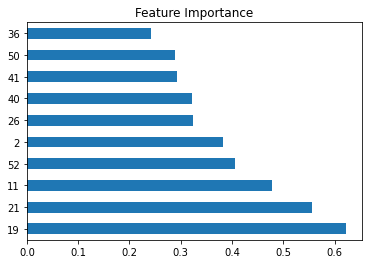

In [53]:
# Graph the Top 10 features in ascending order

importance = LR_classifier.coef_[0]
feat_importance = pd.Series(importance)
feat_importance.nlargest(10).plot(kind='barh',title = 'Feature Importance')

In [54]:
# What are the Top 10 features in importance for the model, ranked from most important to least

feature_names = X.columns
df_feature_names = pd.DataFrame({'features':feature_names})
print(df_feature_names.loc[feat_importance.nlargest(10).index, "features"])

19                      YearsAtCompany
21             YearsSinceLastPromotion
11                  NumCompaniesWorked
52                        OverTime_Yes
2                     DistanceFromHome
26    BusinessTravel_Travel_Frequently
40             JobRole_Human Resources
41       JobRole_Laboratory Technician
50                MaritalStatus_Single
36     EducationField_Technical Degree
Name: features, dtype: object



### Test Models
- Assess classification model accuracy
- Choose best performing model


In [55]:
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [56]:
from random import randint
rand_num = randint(0, len(X))

In [57]:
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]

In [58]:
single_observation

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
494,34,204,14,3,3,31,3,1,3,2579,2912,1,18,3,4,2,8,3,3,8,2,0,6,5,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [59]:
# Spot check the model by making a single prediction
print("This is a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, LR_classifier.predict(scaler.transform(single_observation))))
print("The actual value in the dataframe at row is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

This is a prediction using the LR classifier from a single observation at row 494 [0.]
The actual value in the dataframe at row is 494    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 494    No
Name: Attrition, dtype: object 



## Random Forest



### Build Model



In [60]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit
rf_classifier.fit(X_train_scaled, y_train)

rf_pred = rf_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [61]:
rf_acc_score = accuracy_score(y_test,rf_pred)
print("RF Accuracy Score = {0:.5g}%".format(rf_acc_score * 100))

RF Accuracy Score = 86.735%


In [62]:
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
print("RF Confusion Matrix \n {}".format(rf_confusion_matrix))

RF Confusion Matrix 
 [[251   1]
 [ 38   4]]


In [63]:
balanced_accuracy_score(y_test, rf_pred)

RF_CM = confusion_matrix(y_test, rf_pred)

RF_cm_df = pd.DataFrame(
    RF_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

RF_cm_df.head()


,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,251,1
Actual_low_risk,38,4


In [64]:
# Calculated the balanced accuracy score
rf_pred = rf_classifier.predict(X_test_scaled)
balanced_accuracy_score(y_test, rf_pred)

# Display the confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)


# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, rf_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.87      1.00      0.10      0.93      0.31      0.10       252
        1.0       0.80      0.10      1.00      0.17      0.31      0.09        42

avg / total       0.86      0.87      0.22      0.82      0.31      0.10       294



9          MonthlyIncome
0                    Age
19        YearsAtCompany
16     TotalWorkingYears
1              DailyRate
5             HourlyRate
10           MonthlyRate
2       DistanceFromHome
12     PercentSalaryHike
11    NumCompaniesWorked
Name: features, dtype: object


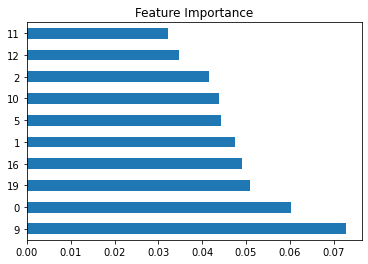

In [65]:
# Graph the Top 10 features in ascending order

importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

feat_importance = pd.Series(importances)
feat_importance.nlargest(10).plot(kind='barh',title = 'Feature Importance')

df_feature_names = pd.DataFrame({'features':feature_names})
print(df_feature_names.loc[feat_importance.nlargest(10).index, "features"])



### Test Models
- Assess classification model accuracy


In [66]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the RF classifier from a single observation at row {} {}".format(rand_num, rf_classifier.predict(scaler.transform(single_observation))))
print("The actual value in the dataframe at row is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the RF classifier from a single observation at row 820 [0.]
The actual value in the dataframe at row is 820    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 820    No
Name: Attrition, dtype: object 



## Support Vector Machine



### Build Model



In [67]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
# Kernel can have values of linear, poly, rbf amongst others.
# linear gives the exact same accuracy as the linear regression classifier, rbf is the next most accurate and poly the least
from sklearn.svm import SVC

svc_classifier = SVC(kernel='rbf', C=2, random_state=44)
svc_classifier.fit(X_train_scaled, y_train)

SVC(C=2, random_state=44)

In [68]:
# Make the predictions
svc_pred = svc_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [69]:
svc_acc_score = accuracy_score(y_test,svc_pred)
print("SVC Accuracy Score = {0:.5g}%".format(svc_acc_score * 100))

SVC Accuracy Score = 89.116%


In [70]:
svc_confusion_matrix = confusion_matrix(y_test, svc_pred)
print("SVC Confusion Matrix \n {}".format(svc_confusion_matrix))

SVC Confusion Matrix 
 [[248   4]
 [ 28  14]]


In [71]:
balanced_accuracy_score(y_test, svc_pred)

SVC_CM = confusion_matrix(y_test, svc_pred)

SVC_cm_df = pd.DataFrame(
    SVC_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

SVC_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,248,4
Actual_low_risk,28,14


In [72]:
# Calculated the balanced accuracy score
svc_pred = svc_classifier.predict(X_test_scaled)
balanced_accuracy_score(y_test, svc_pred)

# Display the confusion matrix
cm = confusion_matrix(y_test, svc_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)


# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, svc_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.90      0.98      0.33      0.94      0.57      0.35       252
        1.0       0.78      0.33      0.98      0.47      0.57      0.31        42

avg / total       0.88      0.89      0.43      0.87      0.57      0.34       294




### Test Models
- Assess classification model accuracy


In [73]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the SVM classifier from a single observation at row {} {}".format(rand_num, svc_classifier.predict(scaler.transform(single_observation))))
print("The actual value in (Attrition_Yes) the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the SVM classifier from a single observation at row 113 [0.]
The actual value in (Attrition_Yes) the original dataframe is 113    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 113    No
Name: Attrition, dtype: object 



## XGBoost



### Build Model



In [74]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.ensemble import GradientBoostingClassifier as XGB

xgb_classifier = XGB(random_state=44)
xgb_classifier.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=44)

In [75]:
# Make the predictions
xgb_pred = xgb_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [76]:
xgb_acc_score = accuracy_score(y_test,xgb_pred)
print("XGBoost Accuracy Score = {0:.5g}%".format(xgb_acc_score * 100))

XGBoost Accuracy Score = 87.755%


In [77]:
xgb_confusion_matrix = confusion_matrix(y_test, xgb_pred)
print("XGB Confusion Matrix \n {}".format(xgb_confusion_matrix))

XGB Confusion Matrix 
 [[247   5]
 [ 31  11]]


In [78]:
balanced_accuracy_score(y_test, xgb_pred)

XGB_CM = confusion_matrix(y_test, xgb_pred)

XGB_cm_df = pd.DataFrame(
    XGB_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

XGB_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,247,5
Actual_low_risk,31,11



### Test Models
- Assess classification model accuracy
- Choose best performing model


In [79]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, xgb_classifier.predict(scaler.transform(single_observation))))
print("The actual value in (Attrition_Yes) the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the dataframe is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 1075 [0.]
The actual value in (Attrition_Yes) the original dataframe is 1075    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the dataframe is 1075    No
Name: Attrition, dtype: object 



## Naive Bayes



### Build Model



In [80]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.naive_bayes import GaussianNB as GNB

In [81]:
gnb_classifier = GNB()
gnb_classifier.fit(X_train_scaled, y_train)

GaussianNB()

In [82]:
# Make the predictions
gnb_pred = gnb_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [83]:
naive_acc_score = accuracy_score(y_test,gnb_pred)
print("Naive Bayes Accuracy Score = {0:.5g}%".format(naive_acc_score * 100))

Naive Bayes Accuracy Score = 62.585%


In [84]:
gnb_confusion_matrix = confusion_matrix(y_test, gnb_pred)
print("XGB Confusion Matrix \n {}".format(gnb_confusion_matrix))

XGB Confusion Matrix 
 [[156  96]
 [ 14  28]]


In [85]:
balanced_accuracy_score(y_test, gnb_pred)

GNB_CM = confusion_matrix(y_test,gnb_pred)

gnb_cm_df = pd.DataFrame(
    GNB_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

gnb_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,156,96
Actual_low_risk,14,28


In [86]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, gnb_classifier.predict(scaler.transform(single_observation))))
print("The actual value for Attrition in the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 335 [1.]
The actual value for Attrition in the original dataframe is 335    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 335    No
Name: Attrition, dtype: object 


## Which model is the most accurate
## We will take the most accurate model and perform hyperparameter tuning to see if we can increase model accuracy

In [87]:
print("LR Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))
print("RF Accuracy Score = {0:.5g}%".format(rf_acc_score * 100))
print("XGBoost Accuracy Score = {0:.5g}%".format(xgb_acc_score * 100))
print("SVC Accuracy Score = {0:.5g}%".format(svc_acc_score * 100))
print("Naive-Bayes Accuracy Score = {0:.5g}%".format(naive_acc_score * 100))

LR Accuracy Score = 89.796%
RF Accuracy Score = 86.735%
XGBoost Accuracy Score = 87.755%
SVC Accuracy Score = 89.116%
Naive-Bayes Accuracy Score = 62.585%



### Hyper parameter tuning
- Grid search - This is the most comprehensive
Since logistic regression was the most accurate, we will attempt to increase it's accuracy using hyperparameter tuning

In [88]:
# Documentation at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV
# There are many many parameters we can adjust in the tuning process, we will try a couple of approaches
# This is the first approach at tuning
# This takes several minutes to run so we will time it

# import the time module
import time
start = time.perf_counter()

lr = LogisticRegression()             # initialize 

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_class_options = ['ovr', 'multinomial']
class_weight_options = ['None', 'balanced']
max_iterations = [100, 200, 500, 1000, 5000, 10000]

param_grid = dict(solver = solver_options, multi_class = 
multi_class_options, class_weight = class_weight_options, max_iter = max_iterations)

grid = GridSearchCV(lr, param_grid, cv=8, scoring = 'accuracy', n_jobs = -1, verbose=4)
grid.fit(X_train_scaled, y_train)
grid.cv_results_

end = time.perf_counter()

# Print the execution time
print("The elapsed time to run this grid search: {} seconds".format(end-start))

Fitting 8 folds for each of 120 candidates, totalling 960 fits
The elapsed time to run this grid search: 163.46523950000002 seconds


C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
336 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py", line 1150, in _fit_liblinear
    class_weigh

In [89]:
grid_df = pd.DataFrame(grid.cv_results_)

In [90]:
grid.best_score_

0.8732993197278912

In [91]:
grid.best_params_

{'class_weight': 'None',
 'max_iter': 100,
 'multi_class': 'ovr',
 'solver': 'newton-cg'}

In [92]:
# The first attempt at hyperparameter tuning actually didn't help the LR algorithm
# Let's try a different set of tuning parameters

# import the time module
import time
start = time.perf_counter()

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100, 200]},
              {'max_iter':[100, 200, 500, 1000, 5000, 10000]}]

grid_diff_parms = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           n_jobs = -1,
                           cv = 8,           
                           verbose=3)

grid_diff_parms.fit(X_train_scaled, y_train)
grid_diff_parms.cv_results_

end = time.perf_counter()

# printing the execution time
print("The elapsed time to run this grid search: {} seconds".format(end-start))

Fitting 8 folds for each of 22 candidates, totalling 176 fits
The elapsed time to run this grid search: 3.531404899999984 seconds


C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 176.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\M037228\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py", l

In [93]:
grid_diff_parms_df = pd.DataFrame(grid_diff_parms.cv_results_)

In [94]:
grid_diff_parms.best_score_

0.8388139466435648

In [95]:
grid_diff_parms.best_params_

{'C': 0.1}


## Run a final test of the chosen model
- Assess classification model accuracy
- Choose best performing model


In [96]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]

print("Make a prediction using the LR classifier from a single observation at row {}. Prediction is {} 0-No, 1-Yes".format(rand_num, LR_classifier.predict(scaler.transform(single_observation))))
print("The actual value of Attrition in the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the databases is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 109. Prediction is [0.] 0-No, 1-Yes
The actual value of Attrition in the original dataframe is 109    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the databases is 109    No
Name: Attrition, dtype: object 



### Finalize Model

## There are many options that can be tried with hyperparameter tuning. We experimented with a number of options but none improved the model accuracy. The final model, which gives the most accurate results is linear regression with an accuracy of 89.8%.